In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

In [4]:
ace_data = pd.read_pickle("../data/../data/ace_data_prepped.pkl")
ace_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   499 non-null    int64   
 1   hospital_reqd        499 non-null    int64   
 2   referral_from        498 non-null    category
 3   age                  499 non-null    int64   
 4   address              499 non-null    category
 5   ethnicity            497 non-null    category
 6   gender               499 non-null    category
 7   allergies            499 non-null    object  
 8   referral_date        499 non-null    category
 9   referral_time        499 non-null    category
 10  illness_severity     497 non-null    category
 11  activity_level       496 non-null    category
 12  gut_feeling          494 non-null    category
 13  ox_sat               489 non-null    float64 
 14  resp_rate            488 non-null    float64 
 15  heart_rate           49

In [5]:
print("General Stats: ")
display(ace_data["hospital_reqd"].agg(["mean", np.std, "count"]))
print("\n")

skip_features = ["id", "hospital_reqd", "age", "heart_rate", "resp_rate",
                 "ox_sat", "temp", "ethnicity", "address", "allergies"]
for feature in ace_data.columns:

    if feature in skip_features:
        continue

    display(HTML(f"<h2>{feature}</h2>"))

    temp_df = ace_data[["hospital_reqd" , feature]]

    display(temp_df.groupby(feature)
            .agg(["mean", np.std, stats.sem, "count"]))

    size_data = (temp_df.groupby([feature, "hospital_reqd"], as_index=False)
                 .size()
                 .pivot(index=feature, columns="hospital_reqd", values="size")
                 .fillna(0))

    chi2, p, dof, expected = chi2_contingency(size_data.values)
    display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
    display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                         index=[0]))
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))

General Stats: 




mean       0.164329
std        0.370945
count    499.000000
Name: hospital_reqd, dtype: float64

hospital_reqd                          
                       mean       std       sem count
referral_from                                        
A&E                0.147368  0.356353  0.036561    95
CCDA               0.048387  0.216335  0.027475    62
ED                 0.100000  0.303822  0.048038    40
GP                 0.202658  0.402649  0.023208   301

,chi2,p,dof
0,10.67596,0.013614,3


hospital_reqd                          
                mean       std       sem count
gender                                        
F           0.148515  0.356493  0.025083   202
M           0.175084  0.380681  0.022089   297

,chi2,p,dof
0,0.439708,0.507263,1


hospital_reqd                          
                       mean       std       sem count
referral_date                                        
Autumn             0.143713  0.351853  0.027227   167
Spring             0.141176  0.350270  0.037992    85
Summer             0.186047  0.391427  0.042209    86
Winter             0.186335  0.390592  0.030783   161

,chi2,p,dof
0,1.711824,0.634308,3


hospital_reqd                          
                       mean       std       sem count
referral_time                                        
Afternoon          0.162437  0.369791  0.026346   197
Evening            0.333333  0.485071  0.114332    18
Morning            0.154930  0.362476  0.021509   284

,chi2,p,dof
0,3.93171,0.140036,2


hospital_reqd                          
                          mean       std       sem count
illness_severity                                        
Mild                  0.149883  0.357375  0.017295   427
Moderate              0.257143  0.440215  0.052616    70

,chi2,p,dof
0,4.273838,0.038703,1


hospital_reqd                          
                        mean       std       sem count
activity_level                                        
lower               0.191860  0.394914  0.030112   172
usual               0.148148  0.355796  0.019766   324

,chi2,p,dof
0,1.267564,0.260224,1


hospital_reqd                          
                     mean       std       sem count
gut_feeling                                        
low concern      0.163701  0.370664  0.022112   281
unwell           0.750000  0.500000  0.250000     4
well             0.153110  0.360958  0.024968   209

,chi2,p,dof
0,10.201133,0.006093,2


hospital_reqd                          
                    mean       std       sem count
sepsis                                            
Low level        0.21875  0.420013  0.074249    32
None noted       0.16060  0.367555  0.017008   467

,chi2,p,dof
0,0.374771,0.540415,1


hospital_reqd                          
                      mean       std       sem count
safeguarding                                        
N                 0.162791  0.369605  0.017824   430
Y                 0.173913  0.381812  0.045965    69

,chi2,p,dof
0,0.003187,0.954978,1


hospital_reqd                          
                      mean       std       sem count
food_allergy                                        
0                 0.156818  0.364043  0.017355   440
1                 0.220339  0.418033  0.054423    59

,chi2,p,dof
0,1.101011,0.294044,1


hospital_reqd                          
                      mean       std       sem count
drug_allergy                                        
0                 0.167756  0.374057  0.017459   459
1                 0.125000  0.334932  0.052957    40

,chi2,p,dof
0,0.227928,0.633065,1


hospital_reqd                          
                       mean       std       sem count
other_allergy                                        
0                  0.167038  0.373426  0.017623   449
1                  0.140000  0.350510  0.049570    50

,chi2,p,dof
0,0.083078,0.773169,1


hospital_reqd                          
                          mean       std       sem count
simple_ethnicity                                        
British               0.162651  0.370163  0.028730   166
Pakistani             0.171548  0.377778  0.024436   239
other                 0.148936  0.357935  0.036918    94

,chi2,p,dof
0,0.256294,0.879724,2


hospital_reqd                          
                         mean       std       sem count
group_ethnicity                                        
asian                0.175373  0.380997  0.023273   268
european             0.167539  0.374438  0.027093   191
other                0.075000  0.266747  0.042176    40

,chi2,p,dof
0,2.576695,0.275726,2


hospital_reqd                         
                    mean      std       sem count
ox_sat_low                                       
0               0.163636  0.37032  0.016645   495
1               0.250000  0.50000  0.250000     4

,chi2,p,dof
0,0.045418,0.831238,1


hospital_reqd                          
                    mean       std       sem count
age_range                                         
pre_school      0.174242  0.380038  0.023390   264
primary         0.141509  0.349371  0.023995   212
secondary       0.260870  0.448978  0.093618    23

,chi2,p,dof
0,2.553815,0.278898,2


hospital_reqd                          
                            mean       std       sem count
ace_heart_rate_cat                                        
high                    0.134021  0.342444  0.034770    97
low                     0.333333  0.500000  0.166667     9
normal                  0.167939  0.374289  0.018880   393

,chi2,p,dof
0,2.558079,0.278304,2


hospital_reqd                          
                           mean       std       sem count
ace_resp_rate_cat                                        
high                   0.177914  0.383619  0.030047   163
low                    0.200000  0.403687  0.054433    55
normal                 0.149466  0.357184  0.021308   281

,chi2,p,dof
0,1.1807,0.554133,2


hospital_reqd                          
                            mean       std       sem count
meets_ace_criteria                                        
0                       0.183946  0.388090  0.022444   299
1                       0.135000  0.342581  0.024224   200

,chi2,p,dof
0,1.749478,0.185942,1


hospital_reqd                          
                             mean       std       sem count
apls_heart_rate_cat                                        
high                     0.240000  0.431419  0.061012    50
low                      0.250000  0.500000  0.250000     4
normal                   0.155056  0.362366  0.017178   445

,chi2,p,dof
0,2.577296,0.275643,2


hospital_reqd                          
                            mean       std       sem count
apls_resp_rate_cat                                        
high                    0.225225  0.419625  0.039829   111
low                     0.000000  0.000000  0.000000     5
normal                  0.148825  0.356382  0.018210   383

,chi2,p,dof
0,4.651088,0.09773,2


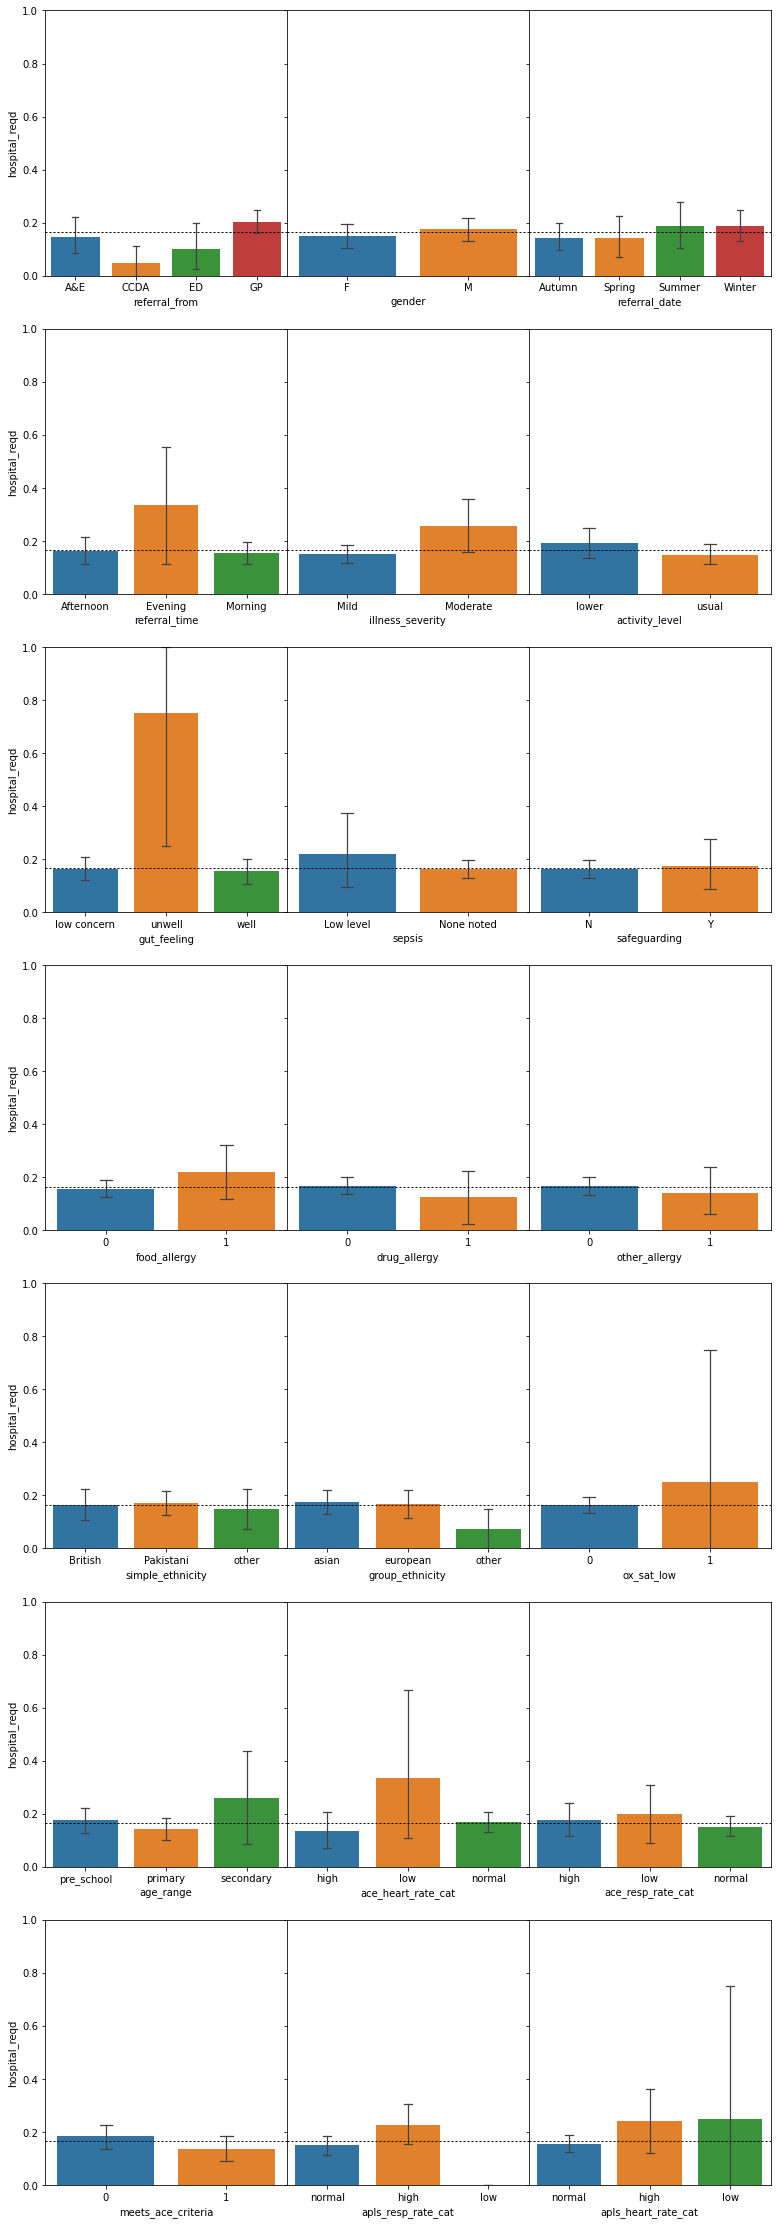

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_plot_features = ['referral_from', 'gender', 'referral_date', 'referral_time',
                     'illness_severity', 'activity_level', 'gut_feeling',
                     'sepsis', 'safeguarding', 'food_allergy', 'drug_allergy',
                     'other_allergy', 'simple_ethnicity', 'group_ethnicity',
                     'ox_sat_low', 'age_range', 'ace_heart_rate_cat',
                     'ace_resp_rate_cat', 'meets_ace_criteria',
                     'apls_resp_rate_cat', 'apls_heart_rate_cat']

fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(13,40))
plt.subplots_adjust(wspace=0)
for n, feature in enumerate(bar_plot_features):
    row, col = int(np.floor(n/3)), n%3
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col])
    # draw line of overall mean hospital admissions
    ax.axhline(ace_data.hospital_reqd.mean(),
               color="black",
               linewidth=1,
               dashes=(2,2))
    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")

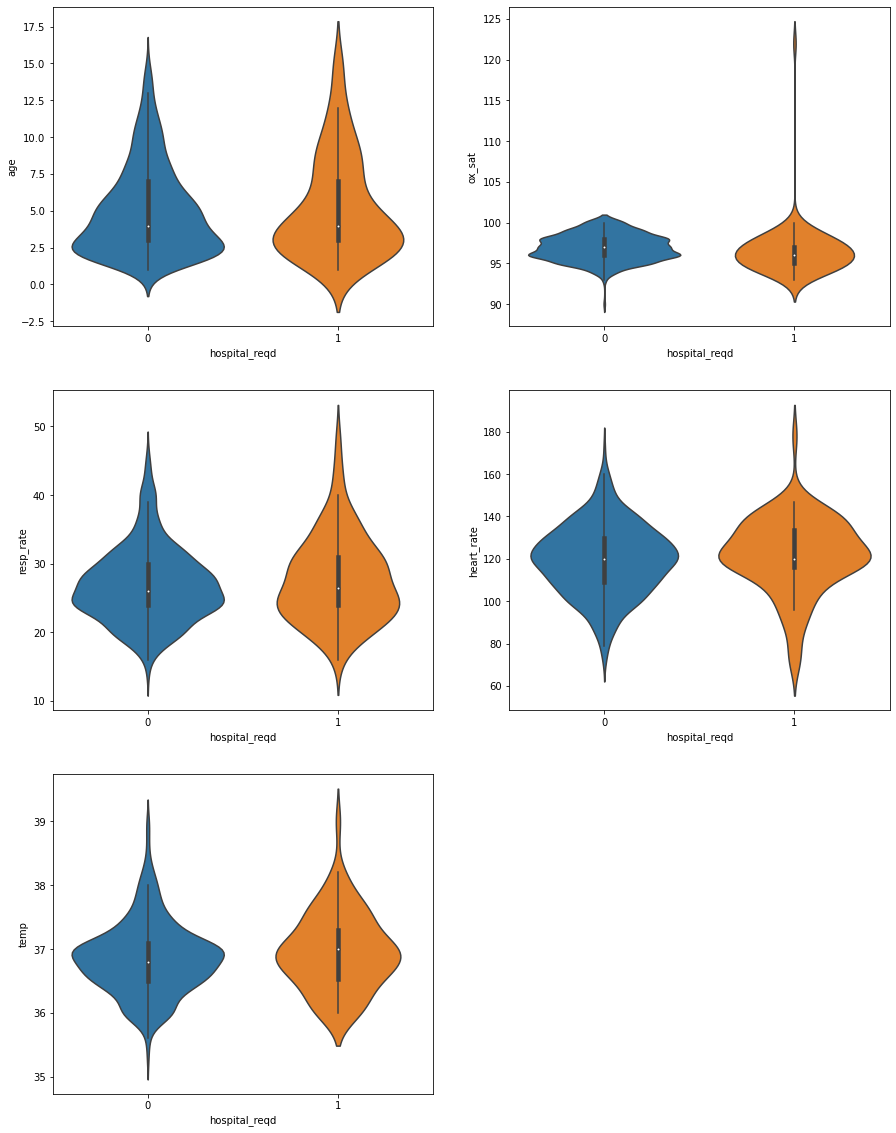

In [7]:
violin_features = ['age', 'ox_sat', 'resp_rate', 'heart_rate', 'temp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,20))
for n, feature in enumerate(violin_features):
    sns.violinplot(data=ace_data,
                   x="hospital_reqd",
                   y=feature,
                   ax=axs[int(np.floor(n/2)), n%2])

axs[2,1].axis("off")

for feature in violin_features:
    display(HTML(f"<h2>{feature}:</h2>"))
    data = ace_data[[feature, "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(data[feature],
                          data.hospital_reqd)
    display(HTML(f"<h3>r: {r}, p: {p}"))
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))

hospital_reqd                          
                       mean       std       sem count
referral_from                                        
A&E                0.147368  0.356353  0.036561    95
CCDA               0.048387  0.216335  0.027475    62
ED                 0.100000  0.303822  0.048038    40
GP                 0.202658  0.402649  0.023208   301

,chi2,p,dof
0,10.67596,0.013614,3


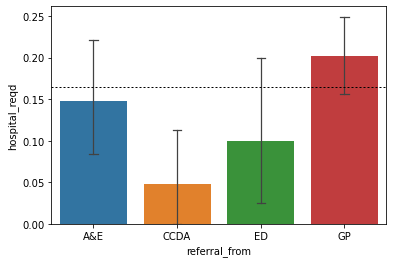

In [48]:
display(HTML(f"<h2>referral_from</h2>"))

temp_df = ace_data[["hospital_reqd" , "referral_from"]]
count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
display(count_df)

size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
             .size()
             .pivot(index="referral_from", columns="hospital_reqd", values="size")
             .fillna(0))

chi2, p, dof, expected = chi2_contingency(size_data.values)
display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                         index=[0]))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))


ax = sns.barplot(data=ace_data,
                 x="referral_from",
                 y="hospital_reqd",
                 errwidth=1.25,
                 capsize=.1)
# draw line of overall mean hospital admissions
ax.axhline(ace_data.hospital_reqd.mean(),
           color="black",
           linewidth=1,
           dashes=(2,2))

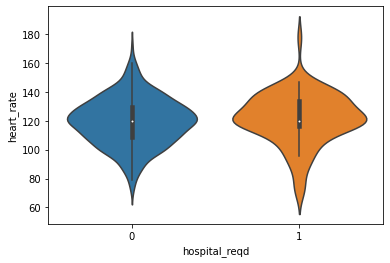

In [49]:
sns.violinplot(data=ace_data,
               x="hospital_reqd",
               y="heart_rate")

display(HTML(f"<h2>heart_rate</h2>"))
data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
r, p = stats.pearsonr(data["heart_rate"],
                      data.hospital_reqd)
display(HTML(f"<h3>r: {r}, p: {p}"))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))

In [63]:
import ipywidgets as widgets

out1 = widgets.Output()
out2 = widgets.Output()

tab = widgets.Accordion(children=[out1, out2])
tab.set_title(0, "referral_from")
tab.set_title(1, "heart_rate")
display(tab)

with out1:
    display(HTML(f"<h2>referral_from</h2>"))

    temp_df = ace_data[["hospital_reqd" , "referral_from"]]
    count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
    display(count_df)

    size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
                 .size()
                 .pivot(index="referral_from", columns="hospital_reqd", values="size")
                 .fillna(0))

    chi2, p, dof, expected = chi2_contingency(size_data.values)
    display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
    display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                             index=[0]))
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))


    bplot = sns.barplot(data=ace_data,
                     x="referral_from",
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1)
    # draw line of overall mean hospital admissions
    bplot.axhline(ace_data.hospital_reqd.mean(),
               color="black",
               linewidth=1,
               dashes=(2,2))
    plt.show(bplot)

with out2:
    vplot = sns.violinplot(data=ace_data, x="hospital_reqd", y="heart_rate")
    display(HTML(f"<h2>heart_rate</h2>"))
    data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(data["heart_rate"],
                          data.hospital_reqd)
    display(HTML(f"<h3>r: {r}, p: {p}"))
    plt.show(vplot)
    if p < 0.05:
        display(HTML("<p style='color:green'>significant</p"))
    else:
        display(HTML("<p style='color:red'>not significant</p"))

Accordion(children=(Output(), Output()), _titles={'0': 'referral_from', '1': 'heart_rate'})

/home/samface/anaconda3/envs/ace_env/lib/python3.8/site-packages/IPython/nbconvert.py:12: ShimWarning: The `IPython.nbconvert` package has been deprecated since IPython 4.0. You should import from nbconvert instead.
  warn("The `IPython.nbconvert` package has been deprecated since IPython 4.0. "
